In [ ]:
import numpy as np
import pandas as pd

# Diploma, Using RuCoLa for summarization quality estimation, 2022

Ponomarev Artem, NLP ABBYY, MIPT

As the summarization dataset we will use gazeta dataset

https://github.com/IlyaGusev/gazeta

In [ ]:
!ls

 classification_report_optimized.txt    roberta_grammatic_17_epochs
 ClassifierTraining.ipynb	        roberta_grammatic_18_epochs
 cuda_11.0.2_450.51.05_linux.run        roberta_grammatic_19_epochs
 Diploma.ipynb			        roberta_grammatic_2_epochs
 first_results.csv		        roberta_grammatic_3_epochs
 gazeta_jsonl			        roberta_grammatic_3epochs
 GeneralClassifier		        roberta_grammatic_4_epochs
 Lexis_1e6_classifier_checkpoints       roberta_grammatic_5_epochs
 MachineClassifier		        roberta_grammatic_6_epochs
 Machine_text_classifier_checkpoints    roberta_grammatic_7_epochs
'MBartSummarizerOutput (1).txt'         roberta_grammatic_8_epochs
 MBartSummarizerOutput_gazeta_val.txt   roberta_grammatic_9_epochs
 MBartSummarizerOutput.txt	        roberta_machine_0_epochs
 new_roberta_grammatic_0_epochs         roberta_machine_1_epochs
 new_roberta_grammatic_1_epochs         roberta_machine_2_epochs
 new_roberta_grammatic_2_epochs         roberta_machine_3_epochs
 Pictures			

In [ ]:
# !tar -C ./gazeta_jsonl -xvf gazeta_jsonl.tar

In [ ]:
data_pd = pd.read_json("./gazeta_jsonl/gazeta_test.jsonl", dtype={ 'text': str, 'summary': str }, lines=True)
print(len(data_pd))

5770


In [ ]:
DATA_LENGTH = 10000

In [ ]:
# Open the dataset:
data_pd = pd.read_json("./gazeta_jsonl/gazeta_val.jsonl", dtype={ 'text': str, 'summary': str }, nrows=DATA_LENGTH, lines=True)

In [ ]:
data_pd = data_pd[['text', 'summary']]

In [ ]:
len(data_pd)

5265

In [ ]:
DATA_LENGTH = min(DATA_LENGTH, len(data_pd))

In [ ]:
data_pd.head()

,text,summary
0,"После громких приобретений Андре Шюррле, Гуса ...",Московский «Спартак» продолжает активную транс...
1,Американское издание The National Interest оце...,Издание The National Interest оценило перспект...
2,Министр иностранных дел России Сергей Лавров с...,"Глава МИД России Сергей Лавров заявил, что в 2..."
3,Минфин предложил с января 2020 года увеличить ...,Министерство финансов предлагает вдвое поднять...
4,Заявление командующего военно-воздушными силам...,Американские ПВО провалились в Саудовской Арав...


In [ ]:
assert DATA_LENGTH == len(data_pd.index)
DATA_LENGTH

5265

# Используем модель для саммаризации, обученную на датасете gazeta

Илья Гусев, 2020, Dataset for Automatic Summarization of Russian News
https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta

In [ ]:
import json
import torch
from transformers import MBartTokenizer, MBartForConditionalGeneration
from datasets import load_dataset
from tqdm import tqdm

class MBartSummarizer:
    def __init__(self, model_name):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"Model device: {self.device}")
        self.tokenizer = MBartTokenizer.from_pretrained(model_name)
        self.model = MBartForConditionalGeneration.from_pretrained(model_name).to(self.device)
        
    def _gen_batch(self, inputs, batch_size):
        batch_start = 0
        while batch_start < len(inputs):
            yield inputs[batch_start: batch_start + batch_size]
            batch_start += batch_size


    def predict(
        self,
        input_records,
        max_source_tokens_count=600,
        batch_size=4,
        print_batch_results=False,
        save_in_file=False,
        output_file="MBartSummarizerOutput.txt"
    ):

        batch_count = len(input_records)//batch_size + 1

        predictions = []
        for batch in tqdm(self._gen_batch(input_records, batch_size), total=batch_count):
            texts = [r["text"] for r in batch]
            input_ids = self.tokenizer(
                texts,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=max_source_tokens_count
            )["input_ids"].to(self.device)

            output_ids = self.model.generate(
                input_ids=input_ids,
                no_repeat_ngram_size=4
            )
            summaries = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)
            
            if print_batch_results:
                for s in summaries:
                    print(s)
            if save_in_file:
                self.save(predictions=summaries, output_file=output_file, output_mode="a+")
            predictions.extend(summaries)
        return predictions
    
    def save(self, predictions, output_file, output_mode="w"):
        with open(output_file, output_mode) as w:
            for p in predictions:
                w.write(p.strip().replace("\n", " ") + "\n")

2022-06-08 14:54:23.296432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 14:54:23.296447: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
summarizer = MBartSummarizer("IlyaGusev/mbart_ru_sum_gazeta")

Model device: cuda


In [ ]:
# Запуск теста
# gazeta_test = load_dataset('IlyaGusev/gazeta')["test"]
# print(type(gazeta_test))
# summarizer.predict(list(gazeta_test), print_batch_results=True)

# Добавим в наш датасет автоматическую саммаризацию

In [ ]:
text_data = [{"text": text} for text in data_pd["text"]]

In [ ]:
predictions = []
with open("MBartSummarizerOutput.txt", 'r') as file:
    for line in file:
        predictions.append(line)

In [ ]:
# predictions = summarizer.predict(text_data, save_in_file=True, output_file='test.txt')

In [ ]:
data_pd = data_pd.assign(mbart_gazeta_summary=predictions)

In [ ]:
# pd.options.display.max_colwidth = 50
pd.options.display.max_colwidth = 1000
data_pd.head()

,text,summary,mbart_gazeta_summary
0,"После громких приобретений Андре Шюррле, Гуса Тиля, Эсекьеля Понсе и Джордана Ларссона , а также покупки Резиуана Мирзова московский «Спартак» не планирует закрывать свою летнюю трансферную кампанию. Красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны. Особенно актуальным данный вопрос стал после ухода бразильского хавбека Фернадо в китайский «Бэйцзин Гоань». Тепень за оборонительные действия в «Спартаке» отвечают Роман Зобнин и Аяз Гулиев , однако их игра вызывает больше негативных оценок, нежели уверенности за результат. В связи с провальными переговорами с чешской «Славией» по покупке опорных полузащитников Алекса Крала и Томаша Соучека представители «народной» команды обратили свой взгляд на чемпионат Франции. Nejvyssi vedeni ruskeho klubu navstivilo v minulych dnech Ceskou republiku. I pri veskerem fotbalem respektu k vyznamu tohoto slavneho klubu Slavia odmitla vubec zahajit i zdvorilostni jednani o obou transferech. Ani jeden nyni neni na prodej. Пос...",Московский «Спартак» продолжает активную трансферную кампанию. Очередным новичком красно-белых может стать опорный полузащитник «Ниццы» Адриен Тамез.,"Московский «Спартак» не планирует закрывать летнюю трансферную кампанию. Красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны. В связи с провальными переговорами с чешской «Славией» по покупке опорных полузащитников Алекса Крала и Томаша Соучека представители «народной» команды обратили свой взгляд на чемпионат Франции.\n"
1,"Американское издание The National Interest оценило перспективный авиационный комплекс дальней авиации (ПАК ДА), отметив, что он станет бомбардировщиком шестого поколения. В настоящее время российские разработчики еще создают летательный аппарат. Журналист СМИ Марк Эпископос сравнил его с истребителем пятого поколения Су-57 и выразил мнение, что ПАК ДА станет представителем «шестого поколения». Автор обратил внимание, что это «фундаментально новый бомбардировщик, созданный на основе современных решений». В то время как ранее оружие создавалось на основе советских проектов. У летательного аппарата будут повышенные стелс-характеристики, улучшенная система пилотирования и расширенные боевые возможности. «Самый поразительный аспект ПАК-ДА — это то, насколько он близок к поступлению на вооружение. Первый прототип ожидается в 2021-2022 годах, пробный полет запланирован на 2025-2026 годы, а серийные поставки начнутся в 2028-2029 годах», — обращает внимание Эпископос, добавив, что первые ис...","Издание The National Interest оценило перспективный российский бомбардировщик ПАК ДА, который отличается от своих предшественников современными решениями, в частности, повышенными стелс-характеристиками. Поражает, насколько быстро летательный аппарат поступит на вооружение, отмечает СМИ.","Американское издание The National Interest оценило перспективный авиационный комплекс дальней авиации (ПАК ДА) и сравнило его с истребителем пятого поколения Су-57. В материале отмечается, что это «фундаментально новый бомбардировщик, созданный на основе современных решений», в то время как ранее оружие создавалось на основе советских проектов.\n"
2,"Министр иностранных дел России Сергей Лавров сообщил, что занимавший на тот момент пост госсекретаря США Джон Керри признавал, что результаты голосования крымчан в марте 2014 года отражают желания жителей полуострова, однако требовал провести повторный референдум в соответствии с нормами международного права. «С какой стати? Если вам все понятно, зачем еще раз гонять людей на какое-то голосование? Надеюсь, Джон [Керри] на меня не обидится», — сказал Лавров в интервью принадлежащему Григорию Березкину РБК. В марте 2014 года в Крыму прошел референдум, по итогам которого полуостров стал территориальной частью России, а Севастополь — городом федерального значения. Украина и большинство западных стран итогов плебисцита не признают. Стоит отметить, что во время своей президентской кампании Дональд Трамп дел

# Получим оценки саммаризации через существующие метрики

# BLEU Experiments (В этом разделе я больше играюсь с метрикой, чем делаю что-то полезное)

In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import (
    sentence_bleu,
    corpus_bleu
)

class BLEUMetrics:
    @staticmethod
    def get_bleu_array(data, ref_column_name, column_name):
        bleu_score_array = np.zeros(DATA_LENGTH)
        for i, (ref, summary) in tqdm(enumerate(zip(data[ref_column_name].astype(str), data[column_name].astype(str))), total=DATA_LENGTH):
            bleu_score_array[i] = sentence_bleu([ref.split()], summary.split())
        return bleu_score_array
    
    @staticmethod
    def get_corpus_bleu(data, ref_column_name, column_name):
        bleu_score_whole_corpus = corpus_bleu(
            [[ref.split()] for ref in list(data[ref_column_name].astype(str))],
            [summary.split() for summary in list(data[column_name].astype(str))]
        )
        return bleu_score_whole_corpus
        

## Посмотрим на метрику по датасету для референса и сгенерированного summary относительно текста:

In [ ]:
bleu_ref_score_array = BLEUMetrics.get_bleu_array(data_pd, "text", "summary")
print(f"Среднее значение BLEU референса к тексту: {bleu_ref_score_array.mean()}")
print(f"Минимальное значение BLEU референса к тексту: {bleu_ref_score_array.min()}")
print(f"Максимальное значение BLEU референса к тексту: {bleu_ref_score_array.max()}")

  0%|                                                                                                                                                                                                                               | 0/5265 [00:00<?, ?it/s]/home/bart/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bart/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  6%|█████████████▌                                              

Среднее значение BLEU референса к тексту: 7.865605738814234e-06
Минимальное значение BLEU референса к тексту: 1.1640585762514036e-246
Максимальное значение BLEU референса к тексту: 0.002930834547642167


In [ ]:
bleu_generated_score_array = BLEUMetrics.get_bleu_array(data_pd, "text", "mbart_gazeta_summary")
print(f"Среднее значение BLEU сгенерированного summary к тексту: {bleu_generated_score_array.mean()}")
print(f"Минимальное значение BLEU сгенерированного summary к тексту: {bleu_generated_score_array.min()}")
print(f"Максимальное значение BLEU сгенерированного summary к тексту: {bleu_generated_score_array.max()}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5265/5265 [00:02<00:00, 2188.22it/s]

Среднее значение BLEU сгенерированного summary к тексту: 0.00012069532314052639
Минимальное значение BLEU сгенерированного summary к тексту: 2.088854940075572e-257
Максимальное значение BLEU сгенерированного summary к тексту: 0.024948333613462017


In [ ]:
print(f"Отношение среднего BLEU референсного к сгенерированному: {bleu_ref_score_array.mean()/bleu_generated_score_array.mean()}")
print(f"Отношение минимального BLEU референсного к сгенерированному: {bleu_ref_score_array.min()/bleu_generated_score_array.min()}")
print(f"Отношение максимального BLEU референсного к сгенерированному: {bleu_ref_score_array.max()/bleu_generated_score_array.max()}")

Отношение среднего BLEU референсного к сгенерированному: 0.06516910128867426
Отношение минимального BLEU референсного к сгенерированному: 55727114119.72387
Отношение максимального BLEU референсного к сгенерированному: 0.11747616466298579


Данные результаты можно объяснить тем, что BLEU смотрит на n-граммы, а сгенерированный текст по своей структуре ближе к исходному. Что, в прочем, не говорит о том, что сгенерированный текст лучше референсного в качестве summary.

In [ ]:
bleu_ref_score_whole_corpus = BLEUMetrics.get_corpus_bleu(data_pd, "text", "summary")
print(f"Значение BLEU по корпусу: {bleu_ref_score_whole_corpus}")

Значение BLEU по корпусу: 5.32300723880786e-07


In [ ]:
bleu_generated_score_whole_corpus = BLEUMetrics.get_corpus_bleu(data_pd, "text", "mbart_gazeta_summary")
print(f"Значение BLEU по корпусу: {bleu_generated_score_whole_corpus}")

Значение BLEU по корпусу: 3.5526175790281664e-06


In [ ]:
print(f"Отношение BLEU референсного summary к сгенерированному на корпусе: {bleu_ref_score_whole_corpus/bleu_generated_score_whole_corpus}")

Отношение BLEU референсного summary к сгенерированному на корпусе: 0.14983338680275265


Результат аналогичен предыдущему эксперименту. Отличающиеся данные связаны с иной методикой подсчета BLEU на корпусе (https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.corpus_bleu)

Очевидно, подобный подход к оценке саммаризации не подходит. Причина в том, что BLEU сравнивает n-граммы, в результате чего сильно отличающиеся тексты не получат высокий результат при оценке.

In [ ]:
metrics_results = pd.DataFrame(columns=["BLEU", "ROUGE_1", "ROUGE_2", "ROUGE_L", "ROUGE_L_SUM", "METEOR", "RUCOLA_METRIC"])
metrics_results.loc[0] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
metrics_results.head()

,BLEU,ROUGE_1,ROUGE_2,ROUGE_L,ROUGE_L_SUM,METEOR,RUCOLA_METRIC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Посмотрим на BLEU между референсом и данными, полученными при машинной саммаризации:

In [ ]:
bleu_ref_generated_score = BLEUMetrics.get_corpus_bleu(data_pd, "summary", "mbart_gazeta_summary")
print(f"BLEU сгенерированного summary относительно референсного: {bleu_ref_generated_score}")
metrics_results.loc[0]["BLEU"] = bleu_ref_generated_score

BLEU сгенерированного summary относительно референсного: 0.08943549525680812


# Metrics PD

In [ ]:
metrics_results = pd.DataFrame(columns=["BLEU", "ROUGE_1", "ROUGE_2", "ROUGE_L", "ROUGE_L_SUM", "METEOR", "RUCOLA_METRIC"])
metrics_results.loc[0] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
metrics_results.head()

# BLEU

Значения метрики довольно низки, но примерно соответствуют результатам автора модели (12.4 BLEU), https://github.com/IlyaGusev/summarus#results-2), что подтверждает корректность эксперимента

In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import (
    sentence_bleu,
    corpus_bleu
)

class BLEUMetrics:
    @staticmethod
    def get_bleu_array(data, ref_column_name, column_name):
        bleu_score_array = np.zeros(DATA_LENGTH)
        for i, (ref, summary) in tqdm(enumerate(zip(data[ref_column_name].astype(str), data[column_name].astype(str))), total=DATA_LENGTH):
            bleu_score_array[i] = sentence_bleu([ref.split()], summary.split())
        return bleu_score_array
    
    @staticmethod
    def get_corpus_bleu(data, ref_column_name, column_name):
        bleu_score_whole_corpus = corpus_bleu(
            [[ref.split()] for ref in list(data[ref_column_name].astype(str))],
            [summary.split() for summary in list(data[column_name].astype(str))]
        )
        return bleu_score_whole_corpus

In [ ]:
bleu_ref_generated_score = BLEUMetrics.get_corpus_bleu(data_pd, "summary", "mbart_gazeta_summary")
print(f"BLEU сгенерированного summary относительно референсного: {bleu_ref_generated_score}")
metrics_results.loc[0]["BLEU"] = bleu_ref_generated_score

# ROUGE

Пример использования

In [ ]:
import evaluate
rouge = evaluate.load('rouge')
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"]
results = rouge.compute(predictions=predictions,
                                             references=references)
print(list(results.keys()))
# ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
print(results["rouge1"])
# AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))
print(results["rouge1"].mid.fmeasure)
# 1.0

Couldn't find a directory or a metric named 'rouge' in this version. It was picked from the master branch on github instead.


['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
1.0


AttributeError: 'numpy.float64' object has no attribute 'mid'

In [ ]:
import evaluate
rouge = evaluate.load('rouge')
predictions = data_pd["mbart_gazeta_summary"].to_numpy()
references = data_pd["summary"].to_numpy()


2022-07-04 03:46:05.507417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 03:46:05.507432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Couldn't find a directory or a metric named 'rouge' in this version. It was picked from the master branch on github instead.


In [ ]:
results = rouge.compute(predictions=predictions,
                                             references=references)

In [ ]:
print(list(results.keys()))
print(results)

print("rouge1\t\t", results["rouge1"])#.mid.fmeasure)
metrics_results.loc[0]["ROUGE_1"] = results["rouge1"]#.mid.fmeasure

print("rouge2\t\t", results["rouge2"])#.mid.fmeasure)
metrics_results.loc[0]["ROUGE_2"] = results["rouge2"]#.mid.fmeasure

print("rougeL\t\t", results["rougeL"])#.mid.fmeasure)
metrics_results.loc[0]["ROUGE_L"] = results["rougeL"]# .mid.fmeasure

print("rougeLsum\t", results["rougeLsum"])#.mid.fmeasure)
metrics_results.loc[0]["ROUGE_L_SUM"] = results["rougeLsum"]#.mid.fmeasure

['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
{'rouge1': 0.21697164382740097, 'rouge2': 0.05542420267954569, 'rougeL': 0.21087714568907878, 'rougeLsum': 0.2106565781688676}
rouge1		 0.21697164382740097
rouge2		 0.05542420267954569
rougeL		 0.21087714568907878
rougeLsum	 0.2106565781688676


In [ ]:
metrics_results.head()

,BLEU,ROUGE_1,ROUGE_2,ROUGE_L,ROUGE_L_SUM,METEOR,RUCOLA_METRIC
0,0.089435,0.216972,0.055424,0.210877,0.210657,0.0,0.0


# METEOR

In [ ]:
meteor = evaluate.load('meteor')
# predictions = ["It is a guide to action which ensures that the military always obeys the commands of the party"]
# references = ["It is a guide to action that ensures that the military will forever heed Party commands"]
results = meteor.compute(predictions=predictions, references=references)

Couldn't find a directory or a metric named 'meteor' in this version. It was picked from the master branch on github instead.
[nltk_data] Downloading package wordnet to /home/bart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/bart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bart/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print(results)

{'meteor': 0.29448801268855873}


In [ ]:
metrics_results.loc[0]["METEOR"] = results["meteor"]

# Соберем нашу метрику из обученных классификаторов

Для этого будем использовать RuRoberta-large https://huggingface.co/sberbank-ai/ruRoberta-large

Обучение классификаторов можно найти в ноутбуке **ClassifierTraining** (**ВНИМАНИЕ**! Код этого ноутбука - черновой и содержит почти все попытки в неотжатом виде; заходить на свой страх и риск, особенно со слабым железом)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers
!pip install sacremoses
!pip install -r /content/gdrive/MyDrive/DiplomaExp/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
DRIVE_PREFIX = "/content/gdrive/MyDrive/DiplomaExp"

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class GlobalClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_general_8_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.65
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class MachineClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_machine_8_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)
        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.61
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class SyntaxClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_syntax_2_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.25
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class HallucinationClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_hallucination_6_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.9
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class SemanticsClassifier: 
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_semantics_8_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.75
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class LexisClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_lexis_14_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.73
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class MorphologyClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_morphology_6_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.64
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from transformers import RobertaForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval


class CommonsenseClassifier:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) 
        state_dict = torch.load(f"{DRIVE_PREFIX}/roberta_commonsense_4_epochs")
        self.model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

        self.model.load_state_dict(state_dict)
        self.device = 'cuda'
        self.model.cuda()
    
    def __call__(self, sentence):
        texts = [sentence]
        encodings = self.tokenizer.batch_encode_plus(texts, padding='longest')
        input_ids = encodings['input_ids']
        attention_masks = encodings['attention_mask']
        
        validation_inputs = torch.tensor(input_ids)
        validation_masks = torch.tensor(attention_masks)
        
        validation_data = TensorDataset(validation_inputs, validation_masks)
        validation_sampler = SequentialSampler(validation_data)
        validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)
        
        num_labels = 1    
        pred_labels = []
        for i, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]

                pred_label = torch.sigmoid(b_logit_pred)

                b_logit_pred = b_logit_pred.detach().cpu().numpy()
                pred_label = pred_label.to(self.device).cpu().numpy()

            pred_labels.append(pred_label)

        pred_labels = [item for sublist in pred_labels for item in sublist]

        threshold = 0.51
        pred_bools = [pl>threshold for pl in pred_labels]
        return pred_bools[0]

In [ ]:
from nltk.tokenize import sent_tokenize
from tqdm import tqdm

class RuColaMetric:
    def __init__(self):
        self.global_weight = 0.2
        self.machine_weight = 0.2
        
        self.global_f1 = 0.83
        self.machine_f1 = 0.86
        
        self.semantics_weight = 0.1
        self.syntax_weight = 0.1
        self.hallucination_weight = 0.1
        self.lexis_weight = 0.1
        self.morphology_weight = 0.1
        self.commonsense_weight = 0.1
        
        self.semantics_f1 = 0.43
        self.syntax_f1 = 0.67
        self.hallucination_f1 = 0.51
        self.lexis_f1 = 0.33
        self.morphology_f1 = 0.31
        self.commonsense_f1 = 0.21
        
        self.normalize_base = (
            self.global_weight * self.global_f1 
            + self.machine_weight * self.machine_f1
            + self.syntax_weight * self.syntax_f1
            + self.hallucination_weight * self.hallucination_f1
            + self.semantics_weight * self.semantics_f1
            + self.morphology_weight * self.morphology_f1
            + self.commonsense_weight * self.commonsense_f1
            + self.lexis_weight * self.lexis_f1
        )
        
        self.global_classifier = GlobalClassifier()
        self.machine_text_classifier = MachineClassifier()
        
        self.semantics_classifier = SemanticsClassifier()
        self.syntax_classifier = SyntaxClassifier()
        self.hallucination_classifier = HallucinationClassifier()
        self.lexis_classifier = LexisClassifier()
        self.morphology_classifier = MorphologyClassifier()
        self.commonsense_classifier = CommonsenseClassifier()

    def pretify(self, model_res):
        results_copy = copy.deepcopy(model_res)
        temp_result_separate = []
        for temp_result in results_copy["separate"]:
            temp_result_separate.append(temp_result[0])
        temp_result_overall = results_copy["overall"][0]
        temp_result_separate_full = []
        for temp_result_array in results_copy["separate_full"]:
            temp_result_separate_full.append([])
            for temp_result in temp_result_array:
                temp_dict = {}
                for key, val in temp_result.items():
                    if key == 'metric':
                        temp_dict[key] = val[0]
                    else:
                        temp_dict[key] = int(math.ceil(val[0]))
                temp_result_separate_full[-1].append(temp_dict)
        return {"overall": temp_result_overall, "separate": temp_result_separate, "separate_full": temp_result_separate_full}

        
    def __call__(self, input_texts):
        result = {"overall": None, "separate": [], "separate_full": []}
        for text in tqdm(input_texts):
            sentences = sent_tokenize(text, language='russian')
 
            error_sum = 0
            result["separate_full"].append([])
            for sentence in sentences:
                is_wrong = ((self.global_classifier(sentence) + 1) % 2) * self.global_weight * self.global_f1
                is_machine = self.machine_text_classifier(sentence) * self.machine_weight * self.machine_f1
                syntax = self.syntax_classifier(sentence) * self.syntax_weight * self.syntax_f1
                semantics = self.semantics_classifier(sentence) * self.semantics_weight * self.semantics_f1
                lexis = self.lexis_classifier(sentence) * self.lexis_weight * self.lexis_f1
                morphology = self.morphology_classifier(sentence) * self.morphology_weight * self.morphology_f1
                commonsense = self.commonsense_classifier(sentence) * self.commonsense_weight * self.commonsense_f1
                hallucination = self.hallucination_classifier(sentence) * self.hallucination_weight * self.hallucination_f1
                
                error_sum += is_wrong
                error_sum += is_machine
                error_sum += syntax
                error_sum += semantics
                error_sum += lexis
                error_sum += morphology
                error_sum += commonsense
                error_sum += hallucination
                
                result["separate_full"][-1].append({
                    "is_wrong": is_wrong,
                    "is_machine": is_machine,
                    "syntax": syntax,
                    "semantics": semantics,
                    "lexis": lexis,
                    "morphology": morphology,
                    "commonsense": commonsense,
                    "hallucination": hallucination,
                    "metric": 1.0 - (is_wrong + is_machine + syntax + semantics + lexis + morphology + commonsense + hallucination)/self.normalize_base
                })
            error = (error_sum / self.normalized_bas) / len(sentences)
            result["separate"].append(1.0 - error)
        
        error_sum = 0
        for error in result["separate"]:
            error_sum += error
        result["overall"] = error_sum / len(result["separate"])
        
        return self.pretify(result)

In [ ]:
rucola_metric = RuColaMetric()

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from 

In [ ]:
DATA_LENGTH = 5625
data_sum = pd.read_json(f"{DRIVE_PREFIX}/gazeta_jsonl/gazeta_val.jsonl", dtype={ 'text': str, 'summary': str }, nrows=DATA_LENGTH, lines=True)
data_sum = data_sum[['text', 'summary']]

In [ ]:
text_data = [{"text": text} for text in data_sum["text"]]
predictions = []
with open(f"{DRIVE_PREFIX}/MBartSummarizerOutput.txt", 'r') as file:
    for line in file:
        predictions.append(line)
data_sum = data_sum.assign(mbart_gazeta_summary=predictions)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Обработка сгенерированного пересказа

In [ ]:
from nltk.tokenize import sent_tokenize

result = rucola_metric(predictions)

100%|██████████| 5265/5265 [39:25<00:00,  2.23it/s]


In [ ]:
print(result["overall"])

0.7903067486800428


Freedman–Diaconis number of bins: 37


Text(0.5, 0, 'Метрика')

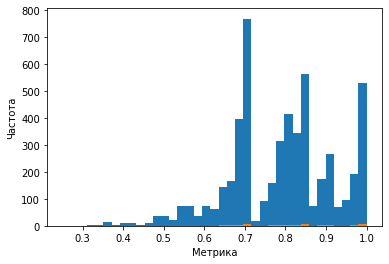

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)
x = np.random.normal(size=1000)

result_per_sentence = result["separate"]

q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins=bins);

plt.hist(x, density=True, bins=bins)
plt.ylabel('Частота')
plt.xlabel('Метрика')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

np.random.seed(42)
x = np.random.normal(size=1000)

import collections

true_counts = collections.defaultdict(int)

labels = ["is_wrong", "is_machine", "syntax", "semantics", "lexis", "morphology", "commonsense", "hallucination"]
counter = 0

result_per_sentence = []
for element in result["separate_full"]:
    for inner_element in element:
        counter += 1
        for label in labels:
            true_counts[label] += int(math.ceil(inner_element[label]))

for label in labels:
    print(f"{label}: {true_counts[label]/counter}, {true_counts[label]} out of {counter}")

is_wrong: 0.1430817610062893, 2002 out of 13992
is_machine: 0.4944968553459119, 6919 out of 13992
syntax: 0.04552601486563751, 637 out of 13992
semantics: 0.00357347055460263, 50 out of 13992
lexis: 0.1996140651801029, 2793 out of 13992
morphology: 0.0067181246426529445, 94 out of 13992
commonsense: 0.0370926243567753, 519 out of 13992
hallucination: 0.000714694110920526, 10 out of 13992


In [ ]:
with open(f"{DRIVE_PREFIX}/metrics_output.txt", 'w+') as file:
    print(result, file=file)

In [ ]:
metrics_results.loc[0]["RUCOLA_METRIC"] = result["overall"]

In [ ]:
metrics_results.head()

,BLEU,ROUGE_1,ROUGE_2,ROUGE_L,ROUGE_L_SUM,METEOR,RUCOLA_METRIC
0,0.089435,0.216972,0.055424,0.210877,0.210657,0.294488,0.729557


In [ ]:
print(len(result["separate"]))

5265


In [ ]:
result_for_sentences = []
array_for_sentences = []
for element in result["separate"]:
    result_for_sentences.append(element)

In [ ]:
data_sum = data_sum.assign(RuCoLA_metric=result_for_sentences)

In [ ]:
data_sum.head()

,text,summary,mbart_gazeta_summary,RuCoLA_metric
0,"После громких приобретений Андре Шюррле, Гуса ...",Московский «Спартак» продолжает активную транс...,Московский «Спартак» не планирует закрывать ле...,0.882991
1,Американское издание The National Interest оце...,Издание The National Interest оценило перспект...,Американское издание The National Interest оце...,0.535103
2,Министр иностранных дел России Сергей Лавров с...,"Глава МИД России Сергей Лавров заявил, что в 2...",Министр иностранных дел России Сергей Лавров з...,0.852740
3,Минфин предложил с января 2020 года увеличить ...,Министерство финансов предлагает вдвое поднять...,Минфин предлагает с 2020 года увеличить сбор з...,1.000000
4,Заявление командующего военно-воздушными силам...,Американские ПВО провалились в Саудовской Арав...,Заявление командующего военно-воздушными силам...,0.834760


In [ ]:
data_sum.to_csv(f"{DRIVE_PREFIX}/df_with_metric.csv", sep='\t')

In [ ]:
import copy

results_copy = copy.deepcopy(result)

In [ ]:
# Вывод до правок в формате вывода
print(results_copy["separate"][:3])

[array([0.93166667]), array([0.7285]), array([0.914])]


In [ ]:
temp_result_separate = []
for temp_result in results_copy["separate"]:
    temp_result_separate.append(temp_result[0])

In [ ]:
temp_result_overall = results_copy["overall"][0]

In [ ]:
# Вывод до правок в формате вывода
print(results_copy["separate_full"][:3])
temp_result_separate_full = []
for temp_result_array in results_copy["separate_full"]:
    temp_result_separate_full.append([])
    for temp_result in temp_result_array:
        temp_dict = {}
        for key, val in temp_result.items():
            if key == 'metric':
                temp_dict[key] = val[0]
            else:
                temp_dict[key] = int(math.ceil(val[0]))
        temp_result_separate_full[-1].append(temp_dict)
print(temp_result_separate_full[:3])

[[{'is_wrong': array([0.]), 'is_machine': array([0.]), 'syntax': array([0.]), 'semantics': array([0.]), 'lexis': array([0.033]), 'morphology': array([0.]), 'commonsense': array([0.]), 'hallucination': array([0.]), 'metric': array([0.94349315])}, {'is_wrong': array([0.]), 'is_machine': array([0.]), 'syntax': array([0.]), 'semantics': array([0.]), 'lexis': array([0.]), 'morphology': array([0.]), 'commonsense': array([0.]), 'hallucination': array([0.]), 'metric': array([1.])}, {'is_wrong': array([0.]), 'is_machine': array([0.172]), 'syntax': array([0.]), 'semantics': array([0.]), 'lexis': array([0.]), 'morphology': array([0.]), 'commonsense': array([0.]), 'hallucination': array([0.]), 'metric': array([0.70547945])}], [{'is_wrong': array([0.]), 'is_machine': array([0.172]), 'syntax': array([0.]), 'semantics': array([0.]), 'lexis': array([0.]), 'morphology': array([0.]), 'commonsense': array([0.]), 'hallucination': array([0.]), 'metric': array([0.70547945])}, {'is_wrong': array([0.166]), 'i

In [ ]:
pretty_result = {"overall": temp_result_overall, "separate": temp_result_separate, "separate_full": temp_result_separate_full}

In [ ]:
with open(f"{DRIVE_PREFIX}/metrics_output_pretty.txt", 'w+') as file:
    print(result, file=file)

In [ ]:
result_avg = 0
for val in result["separate"]:
    result_avg += val
result_avg = (result_avg / len(result["separate"]))**2

disp = 0
result_avg_sqr = 0
for val in result["separate"]:
    result_avg_sqr += val*val
result_avg_sqr /= len(result["separate"])
disp = result_avg_sqr - result_avg

In [ ]:
print(disp)

0.014091604946987246


In [ ]:
bad_examples = [
                "Полностью правильное предложение.",
                "Краене ниграматное, придлажение.",
                "Чут менее неграмотное придлажение.",
                "Покупатели магазина стали невольными зрителями этого происшествия.", # Семантическая ошибка
                "Более неуверенные в себе люди часто одиноки.", # Семантическая ошибка
                "Солнце уже села, когда мы вернулись.", # Синтаксическая ошибка
                "В этом деле играет значение каждая мелочь.", # Синтаксическая ошибка
                "Он пришёл в пальте.", # Морфологическая ошибка
                "На столе лежали две пары чулков", # Морфологическая ошибка
                "Будем бороться до последнего издыхания.", # Лексическая ошибка
                "Не удалось дозвониться до абонемента.", # Лексическая ошибка
]

In [ ]:
bad_result = rucola_metric(bad_examples)

100%|██████████| 11/11 [00:01<00:00,  5.83it/s]


In [ ]:
def pretify(model_res):
    results_copy = copy.deepcopy(model_res)
    temp_result_separate = []
    for temp_result in results_copy["separate"]:
        temp_result_separate.append(temp_result[0])
    temp_result_overall = results_copy["overall"][0]
    temp_result_separate_full = []
    for temp_result_array in results_copy["separate_full"]:
        temp_result_separate_full.append([])
        for temp_result in temp_result_array:
            temp_dict = {}
            for key, val in temp_result.items():
                if key == 'metric':
                    temp_dict[key] = val[0]
                else:
                    temp_dict[key] = int(math.ceil(val[0]))
            temp_result_separate_full[-1].append(temp_dict)
    return {"overall": temp_result_overall, "separate": temp_result_separate, "separate_full": temp_result_separate_full}


In [ ]:
print(bad_result)

{'overall': array([0.89481818]), 'separate': [array([1.]), array([0.47]), array([0.803]), array([1.]), array([1.]), array([0.767]), array([1.]), array([0.803]), array([1.]), array([1.]), array([1.])], 'separate_full': [[{'is_wrong': array([0.]), 'is_machine': array([0.]), 'syntax': array([0.]), 'semantics': array([0.]), 'lexis': array([0.]), 'morphology': array([0.]), 'commonsense': array([0.]), 'hallucination': array([0.]), 'metric': array([1.])}], [{'is_wrong': array([0.166]), 'is_machine': array([0.172]), 'syntax': array([0.067]), 'semantics': array([0.043]), 'lexis': array([0.]), 'morphology': array([0.031]), 'commonsense': array([0.]), 'hallucination': array([0.051]), 'metric': array([0.09246575])}], [{'is_wrong': array([0.166]), 'is_machine': array([0.]), 'syntax': array([0.]), 'semantics': array([0.]), 'lexis': array([0.]), 'morphology': array([0.031]), 'commonsense': array([0.]), 'hallucination': array([0.]), 'metric': array([0.66267123])}], [{'is_wrong': array([0.]), 'is_machi

In [ ]:
print(pretify(bad_result))

{'overall': 0.8948181818181818, 'separate': [1.0, 0.47, 0.8029999999999999, 1.0, 1.0, 0.767, 1.0, 0.8029999999999999, 1.0, 1.0, 1.0], 'separate_full': [[{'is_wrong': 0, 'is_machine': 0, 'syntax': 0, 'semantics': 0, 'lexis': 0, 'morphology': 0, 'commonsense': 0, 'hallucination': 0, 'metric': 1.0}], [{'is_wrong': 1, 'is_machine': 1, 'syntax': 1, 'semantics': 1, 'lexis': 0, 'morphology': 1, 'commonsense': 0, 'hallucination': 1, 'metric': 0.09246575342465757}], [{'is_wrong': 1, 'is_machine': 0, 'syntax': 0, 'semantics': 0, 'lexis': 0, 'morphology': 1, 'commonsense': 0, 'hallucination': 0, 'metric': 0.6626712328767124}], [{'is_wrong': 0, 'is_machine': 0, 'syntax': 0, 'semantics': 0, 'lexis': 0, 'morphology': 0, 'commonsense': 0, 'hallucination': 0, 'metric': 1.0}], [{'is_wrong': 0, 'is_machine': 0, 'syntax': 0, 'semantics': 0, 'lexis': 0, 'morphology': 0, 'commonsense': 0, 'hallucination': 0, 'metric': 1.0}], [{'is_wrong': 1, 'is_machine': 0, 'syntax': 1, 'semantics': 0, 'lexis': 0, 'morpho

# Обработка эталона

In [ ]:
summaries = []
for text in data_sum["summary"]:
    summaries.append(text)

In [ ]:
print(summaries[0])

Московский «Спартак» продолжает активную трансферную кампанию. Очередным новичком красно-белых может стать опорный полузащитник «Ниццы» Адриен Тамез.


In [ ]:
result = rucola_metric(summaries)

100%|██████████| 5265/5265 [43:43<00:00,  2.01it/s]


In [ ]:
result = pretify(result)

In [ ]:
print(result["overall"])

NameError: ignored

In [ ]:
with open(f"{DRIVE_PREFIX}/metrics_etalon_output_pretty.txt", 'w+') as file:
    print(result, file=file)

Freedman–Diaconis number of bins: 32


Text(0.5, 0, 'Метрика')

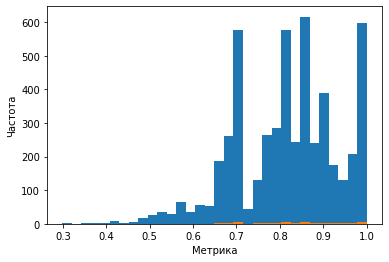

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)
x = np.random.normal(size=1000)

result_per_sentence = []
for element in result["separate"]:
    result_per_sentence.append(element)
x = np.array(result_per_sentence)

q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins=bins);

plt.hist(x, density=True, bins=bins)  # density=False would make counts
plt.ylabel('Частота')
plt.xlabel('Метрика')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

np.random.seed(42)
x = np.random.normal(size=1000)

import collections

true_counts = collections.defaultdict(int)

labels = ["is_wrong", "is_machine", "syntax", "semantics", "lexis", "morphology", "commonsense", "hallucination"]
counter = 0

result_per_sentence = []
for element in result["separate_full"]:
    for inner_element in element:
        counter += 1
        for label in labels:
            true_counts[label] += int(math.ceil(inner_element[label]))

for label in labels:
    print(f"{label}: {true_counts[label]/counter}, {true_counts[label]} out of {counter}")

is_wrong: 0.11777877295118674, 1841 out of 15631
is_machine: 0.43490499648135117, 6798 out of 15631
syntax: 0.04183993346554923, 654 out of 15631
semantics: 0.0031987716716780756, 50 out of 15631
lexis: 0.1755485893416928, 2744 out of 15631
morphology: 0.00467020664064999, 73 out of 15631
commonsense: 0.026101976840893097, 408 out of 15631
hallucination: 6.397543343356151e-05, 1 out of 15631


In [ ]:
pretty_result_avg = 0
for val in result["separate"]:
    pretty_result_avg += val
pretty_result_avg = (pretty_result_avg / len(pretty_result["separate"]))**2

disp = 0
pretty_result_avg_sqr = 0
for val in result["separate"]:
    pretty_result_avg_sqr += val*val
pretty_result_avg_sqr /= len(pretty_result["separate"])
disp = pretty_result_avg_sqr - pretty_result_avg

In [ ]:
print(disp)

0.0048060264167543165


# Исправление смещения (технический раздел для исправления ошибки смещения в поле "separate" выхода метрики, был потерян нормализующий множитель)

In [ ]:
import pandas as pd
import numpy as np
import json
import pickle

In [ ]:
data = ""
with open(f"{DRIVE_PREFIX}/metrics_output_pretty.txt", 'r') as reader:
     # Read & print the entire file
    data = reader.read()

In [ ]:
print(data[:200])
data = data.replace("'", "\"")
result = json.loads(data)

{'overall': 0.7903067486800428, 'separate': [0.8829908675799086, 0.5351027397260273, 0.8527397260273973, 1.0, 0.8347602739726027, 0.7054794520547945, 0.5976027397260273, 0.7568493150684932, 0.82448630


In [ ]:
print(result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
global_weight = 0.2
machine_weight = 0.2

global_f1 = 0.83
machine_f1 = 0.86

semantics_weight = 0.1
syntax_weight = 0.1
hallucination_weight = 0.1
lexis_weight = 0.1
morphology_weight = 0.1
commonsense_weight = 0.1

semantics_f1 = 0.43
syntax_f1 = 0.67
hallucination_f1 = 0.51
lexis_f1 = 0.33
morphology_f1 = 0.31
commonsense_f1 = 0.21

normalize_base = (
    global_weight * global_f1 
    + machine_weight * machine_f1
    + syntax_weight * syntax_f1
    + hallucination_weight * hallucination_f1
    + semantics_weight * semantics_f1
    + morphology_weight * morphology_f1
    + commonsense_weight * commonsense_f1
    + lexis_weight * lexis_f1
)

In [ ]:
for i, val in enumerate(result["separate"]):
    result["separate"][i] = (normalize_base - 1 + val) / normalize_base


In [ ]:
error_sum = 0
for val in result["separate"]:
    error_sum += val
result["overall"] = error_sum / len(result["separate"])

In [ ]:
print(result)

Output hidden; open in https://colab.research.google.com to view.

# Аналогично для эталона

In [ ]:
data = ""
with open(f"{DRIVE_PREFIX}/metrics_etalon_output_pretty.txt", 'r') as reader:
     # Read & print the entire file
    data = reader.read()

In [ ]:
print(data[:200])
data = data.replace("'", "\"")
result = json.loads(data)

{'overall': 0.8172350346817652, 'separate': [0.9717465753424658, 0.5684931506849316, 0.6875, 0.9289383561643836, 0.7106164383561644, 0.779109589041096, 0.8105022831050228, 0.9018264840182648, 0.752996


In [ ]:
print(result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
global_weight = 0.2
machine_weight = 0.2

global_f1 = 0.83
machine_f1 = 0.86

semantics_weight = 0.1
syntax_weight = 0.1
hallucination_weight = 0.1
lexis_weight = 0.1
morphology_weight = 0.1
commonsense_weight = 0.1

semantics_f1 = 0.43
syntax_f1 = 0.67
hallucination_f1 = 0.51
lexis_f1 = 0.33
morphology_f1 = 0.31
commonsense_f1 = 0.21

normalize_base = (
    global_weight * global_f1 
    + machine_weight * machine_f1
    + syntax_weight * syntax_f1
    + hallucination_weight * hallucination_f1
    + semantics_weight * semantics_f1
    + morphology_weight * morphology_f1
    + commonsense_weight * commonsense_f1
    + lexis_weight * lexis_f1
)

In [ ]:
for i, val in enumerate(result["separate"]):
    result["separate"][i] = (normalize_base - 1 + val) / normalize_base

In [ ]:
error_sum = 0
for val in result["separate"]:
    error_sum += val
result["overall"] = error_sum / len(result["separate"])

In [ ]:
print(result)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with open(f"{DRIVE_PREFIX}/metrics_etalon_output_pretty.txt", 'w+') as file:
    print(result, file=file)

In [ ]:
print(normalize_base)

0.5840000000000001
